In [5]:
import os
import numpy as np
from ase.io import read
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from ase.io import read, write

from mol import *

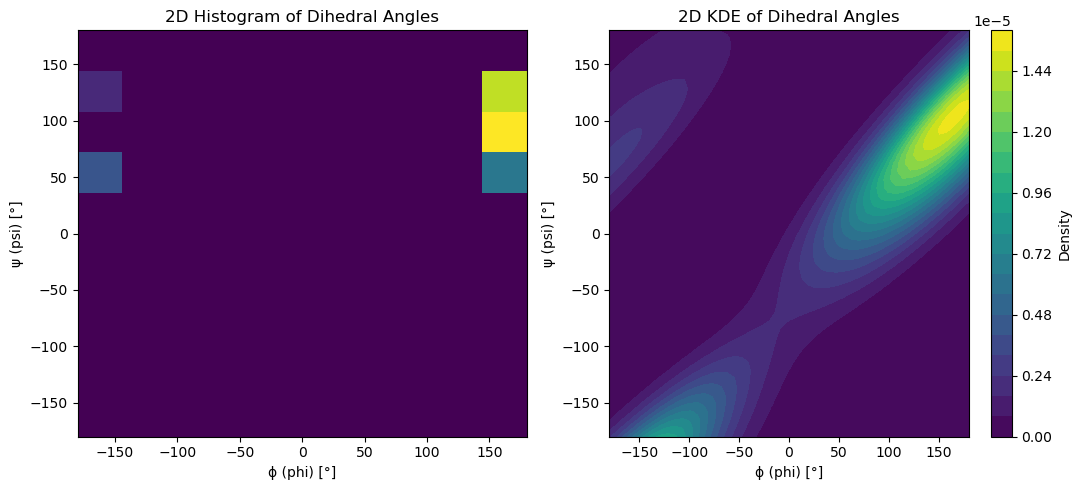

In [6]:
atoms = read("data_ala/all_traj.xyz")
phi_atoms, psi_atoms = get_phi_psi_indices(atoms)
traj = read("data_ala/all_traj.xyz", index=":")

phis, psis = [], []

for atoms in traj:
    phis.append(compute_dihedral(atoms, phi_atoms))
    psis.append(compute_dihedral(atoms, psi_atoms))
    
phis = np.array(phis)
psis = np.array(psis)

phis = np.concatenate([
    phis - 360,
    phis,
    phis + 360
])

psis = np.concatenate([
    psis - 360,
    psis,
    psis + 360
])

data = np.vstack([phis, psis])

# KDE estimation
kde = gaussian_kde(data)
xgrid = np.linspace(-180, 180, 50)
ygrid = np.linspace(-180, 180, 50)
X, Y = np.meshgrid(xgrid, ygrid)
positions = np.vstack([X.ravel(), Y.ravel()])
Z = kde(positions).reshape(X.shape)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(11, 5))

# 2D histogram (counts)
axs[0].hist2d(phis, psis, bins=10, range=[[-180, 180], [-180, 180]], cmap='viridis')
axs[0].set_title("2D Histogram of Dihedral Angles")
axs[0].set_xlabel("ϕ (phi) [°]")
axs[0].set_ylabel("ψ (psi) [°]")
axs[0].set_xlim(-180, 180)
axs[0].set_ylim(-180, 180)

# KDE contour plot
kde_plot = axs[1].contourf(X, Y, Z, levels=20, cmap='viridis')
axs[1].set_title("2D KDE of Dihedral Angles")
axs[1].set_xlabel("ϕ (phi) [°]")
axs[1].set_ylabel("ψ (psi) [°]")
axs[1].set_xlim(-180, 180)
axs[1].set_ylim(-180, 180)
fig.colorbar(kde_plot, ax=axs[1], label="Density")

plt.tight_layout()
plt.show()

Detected 3 dihedrals: {(4, 0, 1, 5), (3, 0, 1, 5), (2, 0, 1, 5)}
Initial dihedral angles: [-180, -61.37508347746774, 61.37508347746774, 180.0]


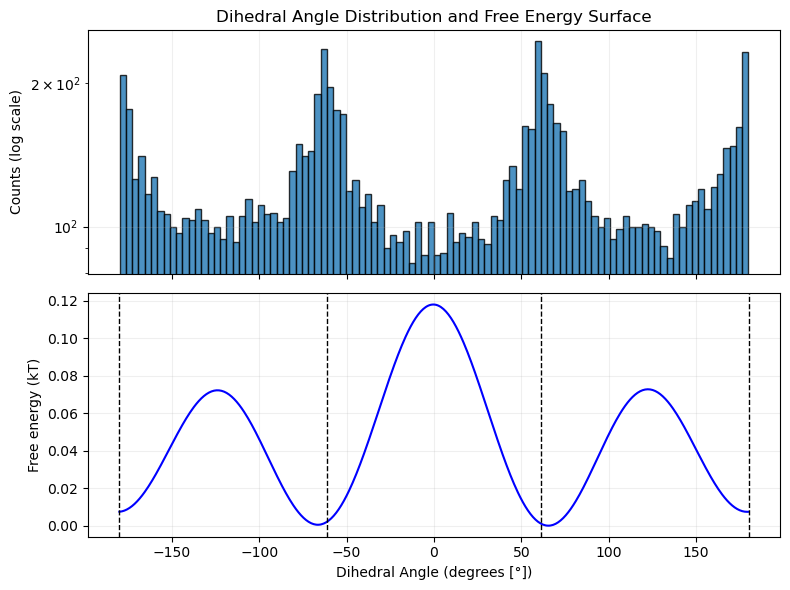

In [7]:
# Load trajectory
atoms = read("data_methanol/initial_optimized.xyz")
initial = atoms.copy()
bonds = get_bonds(atoms)
traj = read("data_methanol/all_traj.xyz",index=':')  # read all frames
dihedral = get_dihedrals(atoms)

initial_dihedral = [-180]
for indices in dihedral:
    initial_dihedral.append(compute_dihedral(initial, indices))

print("Initial dihedral angles:", initial_dihedral)

angles = []
for atoms in traj:
    for indices in dihedral:
        angles.append(compute_dihedral(atoms,indices))

'''
#get the angle and counts for each angle bin
angle_bins = np.linspace(-180, 180, 100)
angle_counts, _ = np.histogram(angles, bins=angle_bins)
# Normalize counts to get free energy surface
angle_counts = angle_counts / np.sum(angle_counts)  # Normalize counts
free_energy_surface = -np.log(angle_counts)
'''
angles = np.array(angles)
# Mirror data to enforce periodicity
angles_extended = np.concatenate([
    angles - 360,
    angles,
    angles + 360
])

# Now apply regular KDE
kde = gaussian_kde(angles_extended)
theta = np.linspace(-180, 180, 500)
pdf = kde(theta)
fes = -np.log(pdf)
fes -= np.min(fes)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Histogram (top)
axs[0].hist(angles, bins=100, density=False, alpha=0.8, edgecolor="black")
axs[0].set_yscale("log")
axs[0].set_ylabel("Counts (log scale)")
axs[0].set_title("Dihedral Angle Distribution and Free Energy Surface")
axs[0].grid(True, alpha=0.2)

# FES (bottom)
#axs[1].plot(angle_bins[:-1], free_energy_surface, label='Free Energy Surface', color='blue')
axs[1].plot(theta,fes, label='Free Energy Surface', color='blue')
axs[1].set_xlabel("Dihedral Angle (degrees [°])")
axs[1].set_ylabel("Free energy (kT)")
axs[1].grid(True, alpha=0.2)
#plot verticle black line at initial dihedral angle
for angle in initial_dihedral:
    axs[1].axvline(angle, color='black', linestyle='--', lw=1, label=f'Initial: {angle:.2f}°')

plt.tight_layout()
plt.show()



In [4]:
#read in data_butane/final_conformers.xyz and use ASE to plot the conformers
final_conformers = read("data_butane/final_conformers.xyz", index=":")
# Plot the final conformers using ase 3d 
from ase.visualize import view
for count_i, i in enumerate(final_conformers):
    #save png
    i.write(f"data_butane/conformer_{count_i + 1}.png")